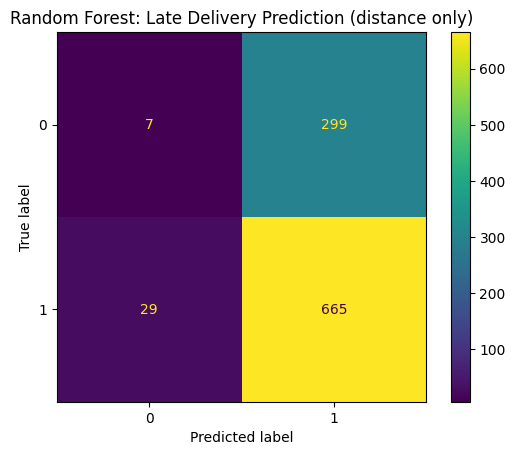

              precision    recall  f1-score   support

           0       0.19      0.02      0.04       306
           1       0.69      0.96      0.80       694

    accuracy                           0.67      1000
   macro avg       0.44      0.49      0.42      1000
weighted avg       0.54      0.67      0.57      1000

Feature importance: [1.]


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import os
from datetime import datetime   

customer = pd.read_excel("customer.xlsx")
warehouse = pd.read_excel("warehouse.xlsx")
sales = pd.read_excel("sales_transactions_star_schema.xlsx")
now_str = datetime.now().strftime("%Y%m%d")

city_coords = {
    'Amsterdam': (52.3676, 4.9041),
    'Hamburg': (53.5511, 9.9937),
    'Barcelona': (41.3851, 2.1734),
    'Washington': (38.8951, -77.0364),
    'Levallois-Perret': (48.8932, 2.2883),
    "Naples": (40.85216, 14.26811),
    "London": (51.509865, -0.118092),
    "Istanbul": (41.015137, 28.979530),
    "Nairobi": (-1.286389, 36.817223),
    "Siena": (43.318611, 11.330556),
    "Istanbul": (41.015137, 28.979530),
    "Madrid": (40.416775, -3.703790),
    "Barcelona": (41.390205, 2.154007),
    "Porto": (41.150223, -8.629932),
    "Boston": (42.360082, -71.058880),
    "Paris": (48.856613, 2.352222),
    "Montpellier": (43.611111, 3.877778),
    "Naples": (40.852160, 14.268110),
    "Athens": (37.983810, 23.727539),
    "Cracow": (50.064650, 19.944980),
    "Vienna": (48.208174, 16.373819),
    "Munich": (48.135125, 11.581981),
    "Marseille": (43.296482, 5.369780),
    "Cluj": (46.771210, 23.623635),
    "Wellington": (-41.286461, 174.776230),
    "Kyoto": (35.011636, 135.768029)
    # Dodaj sve relevantne gradove iz svojih tablica!
}


sales = sales.merge(customer.rename(columns={'name': 'customer'}), on='customer', how='left', suffixes=('', '_customer'))
sales = sales.merge(warehouse, left_on='warehouse_code', right_on='id', how='left', suffixes=('', '_warehouse'))

# 4. latitude/longitude customer/warehause
sales['customer_lat'] = sales['city'].map(lambda x: city_coords.get(str(x), (np.nan, np.nan))[0])
sales['customer_lon'] = sales['city'].map(lambda x: city_coords.get(str(x), (np.nan, np.nan))[1])
sales['warehouse_lat'] = sales['city_warehouse'].map(lambda x: city_coords.get(str(x), (np.nan, np.nan))[0])
sales['warehouse_lon'] = sales['city_warehouse'].map(lambda x: city_coords.get(str(x), (np.nan, np.nan))[1])

# 5. haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

sales['distance_km'] = haversine(
    sales['customer_lat'], sales['customer_lon'],
    sales['warehouse_lat'], sales['warehouse_lon']
)


sales['requested_date'] = pd.to_datetime(sales['requested_date'])
sales['received_date'] = pd.to_datetime(sales['received_date'])
sales['is_late'] = (sales['received_date'] > sales['requested_date']).astype(int)

df_model = sales[['distance_km', 'is_late']].dropna()

X = df_model[['distance_km']]
y = df_model['is_late']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=15)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# 8. Confusion Matrix Display
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest: Late Delivery Prediction (distance only)")
plt.savefig('Confusion_matrix/'  + 'Mario_confusion_matrix_v_' + now_str + '.png', dpi=300, bbox_inches='tight')
plt.show()


print(classification_report(y_test, y_pred))


print("Feature importance:", rf.feature_importances_)